In [136]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

## Base LLM

In [137]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(temperature=0, model="claude-3-5-sonnet-20240620")

## Tavily Search Tool

In [147]:
tavily_search_tool = TavilySearchResults(
    max_results=5,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)


tools = [tavily_search_tool]

In [145]:
tavily_search_tool.invoke({"query": "Any latest news in sports"})

[{'url': 'https://apnews.com/sports',
  'content': 'Tarasenko scores with 5 seconds remaining in the third to give Senators a 5-4 victory over Sharks\nGaiter scores 25 points to lead South Alabama past Marshall 91-85\nToussaint rallies Texas Tech over Kansas State 60-59 for 9th straight victory\nWenzel, Kot lead Wyoming over Fresno State 68-67\nTate scores 15 as Appalachian State knocks off James Madison 59-55\nRiley Kugel scores 20 points, Florida routs Arkansas 90-68 to end 3-game skid against Razorbacks\nUT Arlington wins 80-75 over Seattle\nWoman with car stuck in snow gets help from Packers QB Jordan Love\nTexas State defeats UL Monroe 67-54\nBruner scores 26 and Denver defeats South Dakota State 99-80\nOmot scores 30 to lead North Dakota to 82-69 victory over Kansas City\nJohnson, Buchanan lead George Washington to 83-79 OT win over Davidson\nFordham wins 80-74 over Saint Bonaventure\nTalford scores 27 points as Winthrop knocks off Radford 92-88 in 3OT\nWade Taylor IV scores 31 t

## Chain

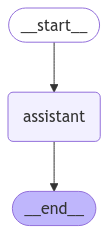

In [148]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}


builder.add_node('assistant', assistant)

builder.add_edge(START, 'assistant')
builder.add_edge('assistant', END)

graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [149]:
from pprint import pprint

result = graph.invoke({'messages': ['hello']})

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today? I'm here to help with any questions or tasks you might have. Is there anything specific you'd like to know or discuss?


In [150]:
result = graph.invoke({'messages': ['Is it raining in bangalore?']})

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

Is it raining in bangalore?
================================== Ai Message ==================================

[{'text': "To answer your question about whether it's raining in Bangalore, I'll need to search for current weather information. Let me do that for you using the available search tool.", 'type': 'text'}, {'id': 'toolu_01FGkJ9idvsHXBoxfEngJJBB', 'input': {'query': 'current weather in Bangalore India'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01FGkJ9idvsHXBoxfEngJJBB)
 Call ID: toolu_01FGkJ9idvsHXBoxfEngJJBB
  Args:
    query: current weather in Bangalore India


## Router

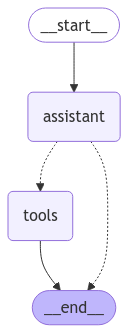

In [153]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}


builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant',
                              # if latest message from assistant is a tool call -> tools condition routes to tools node
                              # if latest message from assistant is not a tool call -> routes to END
                              tools_condition)

builder.add_edge('tools', END)

graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [155]:
result = graph.invoke({'messages': ['Search how is the weather today in Bangalore?']})

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

Search how is the weather today in Bangalore?
================================== Ai Message ==================================

[{'text': "Certainly! I'll use the search function to find current information about the weather in Bangalore for you.", 'type': 'text'}, {'id': 'toolu_01DMzRxj7rk9noS9YV9zjSFd', 'input': {'query': 'current weather in Bangalore today'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01DMzRxj7rk9noS9YV9zjSFd)
 Call ID: toolu_01DMzRxj7rk9noS9YV9zjSFd
  Args:
    query: current weather in Bangalore today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Bangalore', 'region': 'Karnataka', 'country': 'India', 'lat': 12.9833, 'lon': 77.5833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1737

In [164]:
import json

tool_output = json.loads(result['messages'][-1].content)

for m in tool_output:
  print(m['url'])
  print(m['content'])
  print()

https://www.weatherapi.com/
{'location': {'name': 'Bangalore', 'region': 'Karnataka', 'country': 'India', 'lat': 12.9833, 'lon': 77.5833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1737213981, 'localtime': '2025-01-18 20:56'}, 'current': {'last_updated_epoch': 1737213300, 'last_updated': '2025-01-18 20:45', 'temp_c': 22.3, 'temp_f': 72.1, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 10.7, 'wind_kph': 17.3, 'wind_degree': 95, 'wind_dir': 'E', 'pressure_mb': 1017.0, 'pressure_in': 30.03, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 69, 'cloud': 50, 'feelslike_c': 24.7, 'feelslike_f': 76.4, 'windchill_c': 21.8, 'windchill_f': 71.2, 'heatindex_c': 24.5, 'heatindex_f': 76.1, 'dewpoint_c': 16.0, 'dewpoint_f': 60.8, 'vis_km': 6.0, 'vis_miles': 3.0, 'uv': 0.0, 'gust_mph': 14.7, 'gust_kph': 23.6}}

https://www.msn.com/en-in/news/India/bangalore-weather-and-aqi-today-warm-start-at-1594-c-check-weath

In [166]:
result = graph.invoke({'messages': ['What is 9 multiplied by 5']})

In [167]:
for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

What is 9 multiplied by 5
================================== Ai Message ==================================

To answer this question, we don't need to use any external tools or search engines. This is a simple arithmetic calculation that I can perform directly.

9 multiplied by 5 is equal to 45.

This calculation can be done as follows:
9 x 5 = 45

Or you can think of it as adding 9 five times:
9 + 9 + 9 + 9 + 9 = 45

Or as adding 5 nine times:
5 + 5 + 5 + 5 + 5 + 5 + 5 + 5 + 5 = 45

In any case, the result is the same: 45.

Is there anything else you'd like to know about this multiplication or any other mathematical questions I can help you with?


## TOOL LLM LOOP

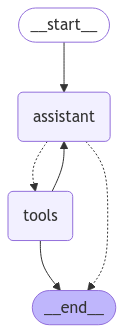

In [168]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}


builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant',
                              # if latest message from assistant is a tool call -> tools condition routes to tools
                              # if latest message from assistant is not a tool call -> routes to END
                              tools_condition)

builder.add_edge('tools', "assistant")
builder.add_edge('tools', END)

graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [169]:
result = graph.invoke({'messages': ['Search how is the weather today in Bangalore? Collect temperature, condition, humidity. If temperature greater than 30 then call it a hot day']})

In [170]:
from pprint import pprint


for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

Search how is the weather today in Bangalore? Collect temperature, condition, humidity. If temperature greater than 30 then call it a hot day
================================== Ai Message ==================================

[{'text': "Certainly! I'll search for the current weather information in Bangalore using the available search tool. Then, I'll analyze the results to provide you with the requested information and determine if it's a hot day based on your criteria.", 'type': 'text'}, {'id': 'toolu_017b6rsymDkLsJkwxJyyAPCg', 'input': {'query': 'current weather Bangalore temperature condition humidity'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_017b6rsymDkLsJkwxJyyAPCg)
 Call ID: toolu_017b6rsymDkLsJkwxJyyAPCg
  Args:
    query: current weather Bangalore temperature condition humidity
================================= Tool Message ========